<a href="https://colab.research.google.com/github/JoHeiberg/greenbox/blob/master/20191130_Twitter__Sanitation2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (1) Scrape #Sanitation from Twitter in 2019 
contains 20.000 tweets using #sanitation between Jan 07th 2019 (13.30h) and Nov 30th 2019 (08.10h)

In [0]:
!pip3 install -qq twint
!pip install -qq whatthelang

     |████████████████████████████████| 1.2MB 13.0MB/s 
     |████████████████████████████████| 245kB 35.8MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 256kB 43.3MB/s 
     |████████████████████████████████| 358kB 43.8MB/s 
     |████████████████████████████████| 204kB 41.2MB/s 
     |████████████████████████████████| 788kB 5.0MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 245kB 43.1MB/s 


In [0]:
# Import Library
import twint

#Standard stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import itertools # Python's amazing iteration & combination library

In [0]:
# Instantiate and configure the twint-object
c = twint.Config() #initialize
c.Store_object = True #store as pandas dataframe
c.Pandas =True
c.Search = ("#sanitation")
c.Since = '2019-01-01'
c.Limit = 20000 # set limit of scrape
c.Lang = 'en' # language, go on twints page on to see other parameters
c.Count = True


In [0]:
# Run search 
twint.run.Search(c)

In [0]:
# Quick check - DataFrame contains several thousand tweets using the exact same text relating to #MYEFO (Australian Mid-Year Economic and Fiscal Outlook), this has likely been generated
twint.storage.panda.Tweets_df.head() #panda! not pandas here

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date
0,1200688516071489536,1200688516071489536,1575101424000,2019-11-30 08:10:24,UTC,,#Sanitation\nSensitization programme was organ...,"[#sanitation, #swachhbharat]",[],758171645437673474,758171645437673474,eobdkmunicipal,Bhadrak Municipality,6,13,https://twitter.com/eobdkmunicipal/status/1200...,False,2,0,1,,#sanitation,,,,,,,"[{'user_id': '758171645437673474', 'username':...",
1,1200687352533925891,1200686315228082176,1575101147000,2019-11-30 08:05:47,UTC,,Are u in nasarawa state? Same thing happening ...,[#sanitation],[],790107391434059776,790107391434059776,Bukar_Ameer,Abubakar Suleiman,3,08,https://twitter.com/Bukar_Ameer/status/1200687...,False,0,0,0,,#sanitation,,,,,,,"[{'user_id': '790107391434059776', 'username':...",
2,1200686315228082176,1200686315228082176,1575100899000,2019-11-30 08:01:39,UTC,,the way i so look forward to spiking as many b...,[#sanitation],[],2975210135,2975210135,khairahssn,`k,7,11,https://twitter.com/khairahssn/status/12006863...,False,19,5,3,,#sanitation,,,,,,,"[{'user_id': '2975210135', 'username': 'khaira...",
3,1200681687488720898,1200681687488720898,1575099796000,2019-11-30 07:43:16,UTC,,#India's toilets: Report questions claims that...,"[#india, #rural, #opendefecation, #bbcnews, #s...",[],858204664902279168,858204664902279168,NagarajuRavadi,Nagaraju Ravadi,1,17,https://twitter.com/NagarajuRavadi/status/1200...,False,0,0,0,,#sanitation,,,,,,,"[{'user_id': '858204664902279168', 'username':...",
4,1200679654023147521,1200679654023147521,1575099311000,2019-11-30 07:35:11,UTC,,"RT swachhbharat Like Sapna, dreams of millions...","[#toilets, #sanitation, #swachhbharat, #zsbp]",[],890106942915563520,890106942915563520,SwachhJalna,Swachh Jalna,3,02,https://twitter.com/SwachhJalna/status/1200679...,False,0,0,0,,#sanitation,,,,,,,"[{'user_id': '890106942915563520', 'username':...",


In [0]:
tweets.hashtags.head()

0                         [#sanitation, #swachhbharat]
1                                        [#sanitation]
2                                        [#sanitation]
3    [#india, #rural, #opendefecation, #bbcnews, #s...
4        [#toilets, #sanitation, #swachhbharat, #zsbp]
Name: hashtags, dtype: object

In [0]:
# Cleanup
tweets = twint.storage.panda.Tweets_df.drop_duplicates(subset=['id']) # get rid of duplicates (of id's of tweets - each tweet has a unique id)

In [0]:
# Reindex
tweets.index = range(len(tweets))

In [0]:
# This function makes easy to handle exceptions (e.g. no text where text should be)
# not really needed but can be useful 

def detect_lang(text):
    try: 
        return wtl.predict_lang(text)
    except: #except Exception can be specified, or except ValueError, or except
        return 'exp'

In [0]:
tweets['lang'] = tweets['tweet'].map(lambda t: detect_lang(t))

In [0]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20011 entries, 0 to 20010
Data columns (total 31 columns):
id                 20011 non-null object
conversation_id    20011 non-null object
created_at         20011 non-null int64
date               20011 non-null object
timezone           20011 non-null object
place              20011 non-null object
tweet              20011 non-null object
hashtags           20011 non-null object
cashtags           20011 non-null object
user_id            20011 non-null int64
user_id_str        20011 non-null object
username           20011 non-null object
name               20011 non-null object
day                20011 non-null int64
hour               20011 non-null object
link               20011 non-null object
retweet            20011 non-null bool
nlikes             20011 non-null int64
nreplies           20011 non-null int64
nretweets          20011 non-null int64
quote_url          20011 non-null object
search             20011 non-null obje

In [0]:
bots = tweets['tweet'].str.contains('#MYEFO') ## retains a series with True for each row containing '#MYEFO' in the tweets column


In [0]:
print (bots)

0        False
1        False
2        False
3        False
4        False
         ...  
20006    False
20007     True
20008     True
20009    False
20010     True
Name: tweet, Length: 20011, dtype: bool


In [0]:
bots = ~(bots) ## inverses boolean series values! 

In [0]:
tweets = tweets[bots.values] ## overwrite tweets df with inversed bots series

In [0]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16380 entries, 0 to 20009
Data columns (total 31 columns):
id                 16380 non-null object
conversation_id    16380 non-null object
created_at         16380 non-null int64
date               16380 non-null object
timezone           16380 non-null object
place              16380 non-null object
tweet              16380 non-null object
hashtags           16380 non-null object
cashtags           16380 non-null object
user_id            16380 non-null int64
user_id_str        16380 non-null object
username           16380 non-null object
name               16380 non-null object
day                16380 non-null int64
hour               16380 non-null object
link               16380 non-null object
retweet            16380 non-null bool
nlikes             16380 non-null int64
nreplies           16380 non-null int64
nretweets          16380 non-null int64
quote_url          16380 non-null object
search             16380 non-null obje

## (2) Create a network graph and export to Gephi - Analyse

In [0]:
# Network Stuff
import networkx as nx
import community # `python-louvain` is implemented here
from networkx.algorithms import bipartite # bipartite NW algos

In [0]:
# Create a new graph
B = nx.Graph()
# We need to specify the nodes for level 0 - this will be our users
B.add_nodes_from(list(set(tweets['id'])), bipartite= 0)
# Then we need to add hashtags nodes as level 1 nodes
B.add_nodes_from(list(set(itertools.chain(*tweets['hashtags']))), bipartite= 1)

In [0]:
B

In [0]:
# This quick loop will generate edges between users and hashtags
# Every time someone mentions a #hashtag, a link is created

bi_edges = []
for i in tweets[['id','hashtags']].iterrows(): # we do this row-by-row since each row is a post
  id_owner = i[1]['id']
  for j in i[1]['hashtags']:
    bi_edges.append((id_owner, j)) # edges are appended to a list as a tuple (id_owner, hashtag)

# Let's add the edges to our graph
B.add_edges_from(bi_edges)

In [0]:
# Extract a set of nodes with level 0
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}

# the remaining nodes are then level 1
bottom_nodes = set(B) - top_nodes

In [0]:
# Let's project this graph using a weighted projection
G_proj = bipartite.weighted_projected_graph(B, bottom_nodes)

In [0]:
len(G_proj)

13456

In [0]:
nx.write_gexf(G_proj, 'Sanitation_2019.gexf') #.gexf file can be analysed in Gephi --> i.e. force atlas % fruchtermann-reinglold visualization +  Lovain algorithm clustering --> first visual inspections of central hashtags

## (3) Save df to json format

In [0]:
# Done # when stored as json (nested format) - you will in most cases any nested structures (if stored in csv - some hierarchical structures may get lost)

tweets.to_json('tweets.json')

##(3) Plot most prominent hashtags over time in Python

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1) #to see more text

import numpy as np
import seaborn as sns

import itertools
from collections import Counter ## to count stuff

In [0]:
# Tokenizing Tweets made easy!
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [0]:
tweets = pd.read_json('/content/tweets.json')

In [0]:
# Get columns of interest into a new DF
tweets_sani_hash = tweets[['tweet', 'hashtags', 'id','created_at']]

In [0]:
# Set Index to datetime

tweets_sani_hash.set_index(pd.to_datetime(tweets_sani_hash.created_at), inplace=True)

In [0]:
# Get most common hashtags - Counter returns tuples

most_common = Counter(itertools.chain(*tweets_sani_hash.hashtags)).most_common(11)

In [0]:
# Isolate the hashtags only
most_common = [x for x,y in most_common][1:]

In [14]:
most_common

['#water',
 '#hygiene',
 '#wash',
 '#sdg6',
 '#health',
 '#swachhbharat',
 '#worldtoiletday',
 '#toilets',
 '#cleanwater',
 '#india']

In [15]:
# Create new columns (one for each hashtag) and fill with 0

for col in most_common:
  tweets_sani_hash[col] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
tweets_sani_hash

,tweet,hashtags,id,created_at,#water,#hygiene,#wash,#sdg6,#health,#swachhbharat,#worldtoiletday,#toilets,#cleanwater,#india
created_at,,,,,,,,,,,,,,
2019-11-30 08:10:24,"#Sanitation\nSensitization programme was organised at RCBL High School on SWM,Plastic Ban & FSSM. About 220 students participated & vowed to be changed agents of Sanitation.\n#SwachhBharat\n@DUDADPMUBHADRAK @DM_Bhadrak @sbmodisha @SwachhBharatGov @FssmOdisha @HUDDeptOdisha pic.twitter.com/hzoc9Dn60Y","[#sanitation, #swachhbharat]",1200688516071489536,2019-11-30 08:10:24,0,0,0,0,0,0,0,0,0,0
2019-11-30 08:05:47,Are u in nasarawa state? Same thing happening here #sanitation,[#sanitation],1200687352533925888,2019-11-30 08:05:47,0,0,0,0,0,0,0,0,0,0
2019-11-30 08:01:39,the way i so look forward to spiking as many ball as possible this morning only to find the street empty #sanitation 🤕🤕🤕🤕🤕🤕🚶 pic.twitter.com/oGdodUz1Da,[#sanitation],1200686315228082176,2019-11-30 08:01:39,0,0,0,0,0,0,0,0,0,0
2019-11-30 07:43:16,#India's toilets: Report questions claims that #rural areas are free from #opendefecation\n#bbcnews\n#sanitation #SwachhBharat https://www.bbc.co.uk/news/world-asia-india-46400678 …,"[#india, #rural, #opendefecation, #bbcnews, #sanitation, #swachhbharat]",1200681687488720896,2019-11-30 07:43:16,0,0,0,0,0,0,0,0,0,0
2019-11-30 07:35:11,"RT swachhbharat Like Sapna, dreams of millions of girls from across the nation are being realized because of regular usage of #toilets. Be a part of this change and contribute to sustaining the practice of safe #sanitation. Watch👇\n https://www.youtube.com/watch?v=2iG3jNZeEJc … #SwachhBharat #ZSBP","[#toilets, #sanitation, #swachhbharat, #zsbp]",1200679654023147520,2019-11-30 07:35:11,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07 15:40:47,"Many who live in deprived settings with no access to adequate #water and #sanitation spend much of their day collecting #water – a responsibility that is borne by women, girls and children in most communities in #Africa. #Advocate for #Water & #HumanRights #SDGs @EndWaterPoverty pic.twitter.com/kzj5GvFuHM","[#water, #sanitation, #water, #africa, #advocate, #water, #humanrights, #sdgs]",1082301027234258944,2019-01-07 15:40:47,0,0,0,0,0,0,0,0,0,0
2019-01-07 15:20:30,A Sato Pan. Does away with the need for a waterseal. Uses less water for flushing. Inventions I like. #sanitation pic.twitter.com/oCUFHMFdUk,[#sanitation],1082295921428164608,2019-01-07 15:20:30,0,0,0,0,0,0,0,0,0,0
2019-01-07 14:00:43,New app rates restaurant cleanliness. https://buff.ly/2LRf6p6 #sanitation #app pic.twitter.com/nQAejOVxFV,"[#sanitation, #app]",1082275842401673216,2019-01-07 14:00:43,0,0,0,0,0,0,0,0,0,0


In [17]:
# Iterate over hashtags and fill in the corresponding columns with 1 if hashtag present in a tweet- for each element in most_common, map is applied 
for hashtag in most_common:
  tweets_sani_hash[hashtag] = tweets_sani_hash['hashtags'].map(lambda t: 1 if hashtag in t else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
tweets_sani_hash ## any time one of the important hashtags appears a 1 is assigned to the respective column

,tweet,hashtags,id,created_at,#water,#hygiene,#wash,#sdg6,#health,#swachhbharat,#worldtoiletday,#toilets,#cleanwater,#india
created_at,,,,,,,,,,,,,,
2019-11-30 08:10:24,"#Sanitation\nSensitization programme was organised at RCBL High School on SWM,Plastic Ban & FSSM. About 220 students participated & vowed to be changed agents of Sanitation.\n#SwachhBharat\n@DUDADPMUBHADRAK @DM_Bhadrak @sbmodisha @SwachhBharatGov @FssmOdisha @HUDDeptOdisha pic.twitter.com/hzoc9Dn60Y","[#sanitation, #swachhbharat]",1200688516071489536,2019-11-30 08:10:24,0,0,0,0,0,1,0,0,0,0
2019-11-30 08:05:47,Are u in nasarawa state? Same thing happening here #sanitation,[#sanitation],1200687352533925888,2019-11-30 08:05:47,0,0,0,0,0,0,0,0,0,0
2019-11-30 08:01:39,the way i so look forward to spiking as many ball as possible this morning only to find the street empty #sanitation 🤕🤕🤕🤕🤕🤕🚶 pic.twitter.com/oGdodUz1Da,[#sanitation],1200686315228082176,2019-11-30 08:01:39,0,0,0,0,0,0,0,0,0,0
2019-11-30 07:43:16,#India's toilets: Report questions claims that #rural areas are free from #opendefecation\n#bbcnews\n#sanitation #SwachhBharat https://www.bbc.co.uk/news/world-asia-india-46400678 …,"[#india, #rural, #opendefecation, #bbcnews, #sanitation, #swachhbharat]",1200681687488720896,2019-11-30 07:43:16,0,0,0,0,0,1,0,0,0,1
2019-11-30 07:35:11,"RT swachhbharat Like Sapna, dreams of millions of girls from across the nation are being realized because of regular usage of #toilets. Be a part of this change and contribute to sustaining the practice of safe #sanitation. Watch👇\n https://www.youtube.com/watch?v=2iG3jNZeEJc … #SwachhBharat #ZSBP","[#toilets, #sanitation, #swachhbharat, #zsbp]",1200679654023147520,2019-11-30 07:35:11,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07 15:40:47,"Many who live in deprived settings with no access to adequate #water and #sanitation spend much of their day collecting #water – a responsibility that is borne by women, girls and children in most communities in #Africa. #Advocate for #Water & #HumanRights #SDGs @EndWaterPoverty pic.twitter.com/kzj5GvFuHM","[#water, #sanitation, #water, #africa, #advocate, #water, #humanrights, #sdgs]",1082301027234258944,2019-01-07 15:40:47,1,0,0,0,0,0,0,0,0,0
2019-01-07 15:20:30,A Sato Pan. Does away with the need for a waterseal. Uses less water for flushing. Inventions I like. #sanitation pic.twitter.com/oCUFHMFdUk,[#sanitation],1082295921428164608,2019-01-07 15:20:30,0,0,0,0,0,0,0,0,0,0
2019-01-07 14:00:43,New app rates restaurant cleanliness. https://buff.ly/2LRf6p6 #sanitation #app pic.twitter.com/nQAejOVxFV,"[#sanitation, #app]",1082275842401673216,2019-01-07 14:00:43,0,0,0,0,0,0,0,0,0,0


In [0]:
# Import plotting stuff
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,10)})

In [20]:
# count up occurence of hashtags in timeframe of interest, .resample'D' is a method of dataframes that have datetime-readable inputs!!

tweets_sani_hash.resample('M')[most_common].sum()

,#water,#hygiene,#wash,#sdg6,#health,#swachhbharat,#worldtoiletday,#toilets,#cleanwater,#india
created_at,,,,,,,,,,
2019-01-31,238,94,81,131,145,65,3,138,21,43
2019-02-28,293,137,86,87,55,65,0,37,23,58
2019-03-31,543,303,135,124,79,139,2,33,76,51
2019-04-30,321,159,118,71,83,42,0,28,27,33
2019-05-31,294,156,91,56,55,54,1,37,36,24
2019-06-30,311,130,129,58,72,30,0,34,38,33
2019-07-31,310,175,148,87,88,62,2,26,49,21
2019-08-31,387,132,136,70,73,49,0,27,45,21
2019-09-30,326,143,110,83,71,56,2,18,43,44


In [21]:
!pip install -qq holoviews
!pip install -qq -U bokeh

     |████████████████████████████████| 4.0MB 9.6MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 32.4MB 73kB/s 


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
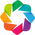

In [22]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show


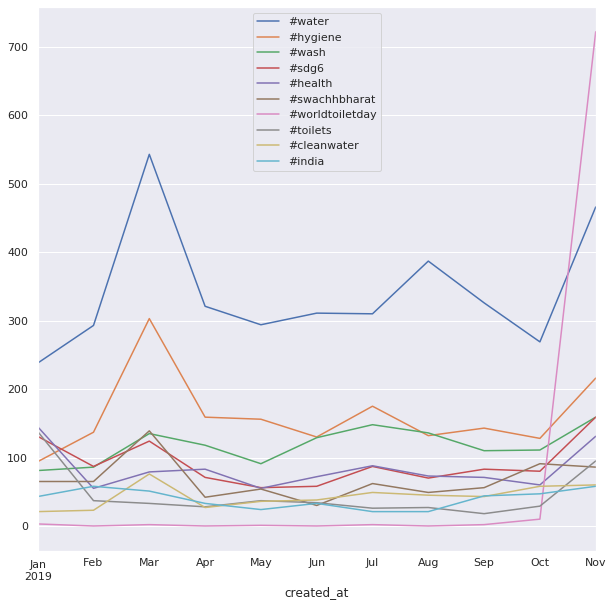

In [23]:
# Count up and plot in one go
tweets_sani_hash.resample('M')[most_common].sum().plot()

## (4) LDA analysis of the #sanitation dataset

Filtering the corpus using tweet-preprocessor 
Cleaning up further with SpaCy (keep only ADV, ADJ, NOUN)
Using Gensim to build a Dictionary (Filtering extremes) and Corpus
Using Gensim to run LDA
Identifying 10 topics
Plotting topic-counts by day

In [0]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load("en")

In [25]:
! pip install tweet-preprocessor
import preprocessor as p

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=aa3793ca09e98728805f29a7be8d4840bed7da8d758177fa5cca526ca96ff909
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


In [0]:
from nltk.tokenize import TweetTokenizer
tknrz = TweetTokenizer()

In [0]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.HASHTAG)

## (4.1) Preprocessing

In [28]:
tweets_sani_hash.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16380 entries, 2019-11-30 08:10:24 to 2019-01-07 13:35:07
Data columns (total 14 columns):
tweet              16380 non-null object
hashtags           16380 non-null object
id                 16380 non-null int64
created_at         16380 non-null datetime64[ns]
#water             16380 non-null int64
#hygiene           16380 non-null int64
#wash              16380 non-null int64
#sdg6              16380 non-null int64
#health            16380 non-null int64
#swachhbharat      16380 non-null int64
#worldtoiletday    16380 non-null int64
#toilets           16380 non-null int64
#cleanwater        16380 non-null int64
#india             16380 non-null int64
dtypes: datetime64[ns](1), int64(11), object(2)
memory usage: 2.5+ MB


In [0]:
sani_tweets = tweets_sani_hash

In [0]:
#Cleaning with pre-processor
tweets_clean = sani_tweets.tweet.map(p.clean)

In [31]:
#Tokenize
tknzr = TweetTokenizer (strip_handles=True)
sani_tweets['tokenized']= tweets_clean.map(lambda t: tknzr.tokenize(t))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
#Remove numbers etc.
sani_tweets['tokenized'] = sani_tweets['tokenized'].map(lambda t: [token.strip('@') for token in t if token.isalnum()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
## Join back into string for spacy
sani_tweets['tokenized'] = sani_tweets['tokenized'].map(lambda t: ' '.join(t))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
sani_tweets['tokenized']

created_at
2019-11-30 08:10:24    Sensitization programme was organised at RCBL High School on SWM Plastic Ban FSSM About 220 students participated vowed to be changed agents of Sanitation                                                
2019-11-30 08:05:47    Are u in nasarawa state Same thing happening here                                                                                                                                                         
2019-11-30 08:01:39    the way i so look forward to spiking as many ball as possible this morning only to find the street empty                                                                                                  
2019-11-30 07:43:16    s toilets Report questions claims that areas are free from                                                                                                                                                
2019-11-30 07:35:11    swachhbharat Like Sapna dreams of millions of girls from acros

## (4.2) Clean up further with SpaCy (keep only ADV, ADJ, NOUN) 

In [0]:
# now, let's combine everything that we learned about preprocessing in a few lines of code -> spacy also does the tokenization

tokens = []

for summary in nlp.pipe(sani_tweets['tokenized']):
  proj_tok = [token.lemma_.lower() for token in summary if token.pos_ in ['NOUN', 'ADJ', 'ADV'] and not token.is_stop] 
  tokens.append(proj_tok)

In [36]:
# Bringing tokens back in
sani_tweets['tokens'] = tokens

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
sani_tweets['tokens'][:10]

created_at
2019-11-30 08:10:24    [sensitization, programme, student, agent]                                                       
2019-11-30 08:05:47    [nasarawa, state, thing]                                                                         
2019-11-30 08:01:39    [way, forward, ball, possible, morning, street]                                                  
2019-11-30 07:43:16    [s, toilet, question, claim, area, free]                                                         
2019-11-30 07:35:11    [dream, million, girl, nation, regular, usage, change, practice, safe]                           
2019-11-30 07:30:00    [dream, million, girl, nation, regular, usage, change, practice, safe]                           
2019-11-30 05:47:57    [door, collection, segregated, waste, lifting, drain, cleaning, road, moto, environment, healthy]
2019-11-30 05:35:56    []                                                                                               
2019-11-29 21:43:59  

In [38]:
sani_tweets['tokens']

created_at
2019-11-30 08:10:24    [sensitization, programme, student, agent]                                                       
2019-11-30 08:05:47    [nasarawa, state, thing]                                                                         
2019-11-30 08:01:39    [way, forward, ball, possible, morning, street]                                                  
2019-11-30 07:43:16    [s, toilet, question, claim, area, free]                                                         
2019-11-30 07:35:11    [dream, million, girl, nation, regular, usage, change, practice, safe]                           
                                                        ...                                                             
2019-01-07 15:40:47    [setting, access, day, responsibility, woman, girl, child, community]                            
2019-01-07 15:20:30    [sato, away, need, waterseal, water]                                                             
2019-01-07 14:00:43  

## (4.3) Using Gensim to build a Dictionary (Filter extremes) and Corpus

In [39]:
!pip install -qq -U gensim # once tokenization is finished, NLP can be done in gensim --> here focus is on semantics --> what do discourse cluster talk about

     |████████████████████████████████| 24.2MB 99kB/s 


In [0]:
# Import the dictionary builder
from gensim.corpora.dictionary import Dictionary

In [0]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(sani_tweets['tokens'])

In [0]:
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words, experiment with this
dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)

In [43]:
[doc for doc in dictionary.items()]

[(0, 'agent'),
 (1, 'programme'),
 (2, 'student'),
 (3, 'state'),
 (4, 'thing'),
 (5, 'forward'),
 (6, 'morning'),
 (7, 'possible'),
 (8, 'street'),
 (9, 'way'),
 (10, 'area'),
 (11, 'free'),
 (12, 'question'),
 (13, 's'),
 (14, 'toilet'),
 (15, 'change'),
 (16, 'dream'),
 (17, 'girl'),
 (18, 'million'),
 (19, 'nation'),
 (20, 'practice'),
 (21, 'regular'),
 (22, 'safe'),
 (23, 'usage'),
 (24, 'cleaning'),
 (25, 'collection'),
 (26, 'door'),
 (27, 'drain'),
 (28, 'environment'),
 (29, 'healthy'),
 (30, 'road'),
 (31, 'waste'),
 (32, 'conversation'),
 (33, 'good'),
 (34, 'great'),
 (35, 'platform'),
 (36, 'article'),
 (37, 'away'),
 (38, 'garbage'),
 (39, 'stuff'),
 (40, 'condition'),
 (41, 'country'),
 (42, 'employee'),
 (43, 'sanitation'),
 (44, 'working'),
 (45, 'world'),
 (46, 'job'),
 (47, 'link'),
 (48, 'challenge'),
 (49, 'context'),
 (50, 'day'),
 (51, 'end'),
 (52, 'excellent'),
 (53, 'high'),
 (54, 'innovative'),
 (55, 'operation'),
 (56, 'plant'),
 (57, 'product'),
 (58, 'qua

In [0]:
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in sani_tweets['tokens']]

In [45]:
# That's how the corpus looks, # for each corpus, give the first 10 rows each word (indexed) followed by its count (0,2)
corpus

[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)],
 [(15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [],
 [(32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1), (39, 1)],
 [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(46, 1), (47, 1)],
 [(48, 1),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(64, 1)],
 [(65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)],
 [(71, 1)],
 [],
 [(9, 1), (72, 1), (73, 1)],
 [(14, 1), (60, 1), (74, 1), (75, 1)],
 [(62, 1), (76, 1), (77, 1), (78, 1)],
 [(62, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)],


## (4.4) Using Gensim to run LDA, Identifying 10 topics

In [0]:
# we'll use the faster multicore version of LDA

from gensim.models import LdaMulticore

In [0]:
# Training the model (makes some mess atm due to version clashes) - there are methods on finding out how many topics would make sense num_topics

lda_model = LdaMulticore(corpus, id2word=dictionary,  num_topics=10, workers = 4, passes=10)

In [48]:
# Check out topics
lda_model.print_topics(-1)

[(0,
  '0.108*"water" + 0.037*"right" + 0.033*"clean" + 0.030*"sanitation" + 0.030*"safe" + 0.029*"people" + 0.028*"access" + 0.025*"human" + 0.021*"drinking" + 0.019*"new"'),
 (1,
  '0.034*"today" + 0.031*"school" + 0.022*"campaign" + 0.018*"awareness" + 0.017*"initiative" + 0.016*"change" + 0.015*"important" + 0.015*"activity" + 0.014*"message" + 0.013*"safe"'),
 (2,
  '0.050*"year" + 0.045*"sanitation" + 0.038*"people" + 0.035*"toilet" + 0.026*"access" + 0.022*"disease" + 0.020*"day" + 0.019*"global" + 0.018*"future" + 0.018*"action"'),
 (3,
  '0.069*"access" + 0.057*"service" + 0.039*"water" + 0.037*"sanitation" + 0.029*"facility" + 0.028*"project" + 0.025*"people" + 0.021*"basic" + 0.018*"country" + 0.017*"rural"'),
 (4,
  '0.032*"great" + 0.020*"thank" + 0.019*"challenge" + 0.017*"development" + 0.016*"sanitation" + 0.015*"effort" + 0.013*"good" + 0.013*"sector" + 0.013*"research" + 0.013*"opportunity"'),
 (5,
  '0.030*"waste" + 0.027*"worker" + 0.026*"sanitation" + 0.025*"week" 

## (4.5) Visualize

In [49]:
##  installing a cool visualizer
!pip install -qq pyLDAvis

     |████████████████████████████████| 1.6MB 10.4MB/s 
     |████████████████████████████████| 552kB 44.0MB/s 


In [0]:
# and import it
import pyLDAvis.gensim
%matplotlib inline
pyLDAvis.enable_notebook()


In [51]:
## Let's try to visualize
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [52]:
# Let's Visualize --> such visualizations are helpful for focus groups - give these topic modelling inputs 
pyLDAvis.display(lda_display)

In [53]:
# Which topic does a tweet belong to?
lda_model[corpus][8]

[(0, 0.020009689),
 (1, 0.020001484),
 (2, 0.020003017),
 (3, 0.020001234),
 (4, 0.5742614),
 (5, 0.020001926),
 (6, 0.020002235),
 (7, 0.02000427),
 (8, 0.020001344),
 (9, 0.26571336)]

In [54]:
# And that's how you get the topic-number that's ranked highest

print(sorted([(2, 0.121567), (9, 0.8610384)], key=lambda x: -x[1]))
print(sorted([(2, 0.121567), (9, 0.8610384)], key=lambda x: -x[1])[0][0])

[(9, 0.8610384), (2, 0.121567)]
9


In [0]:
tweets_and_topics = lda_model[corpus]

In [0]:
topics = []
for tweet in tweets_and_topics:
  topics.append(sorted(tweet,  key=lambda x: -x[1])[0][0])

In [57]:
sani_tweets['topics'] = topics

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
most_common1 = [0,1,2,3,4,5,6,7,8,9]
for col in most_common1:
  sani_tweets[col]= 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
sani_tweets

,tweet,hashtags,id,created_at,#water,#hygiene,#wash,#sdg6,#health,#swachhbharat,#worldtoiletday,#toilets,#cleanwater,#india,tokenized,tokens,topics,0,1,2,3,4,5,6,7,8,9
created_at,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30 08:10:24,"#Sanitation\nSensitization programme was organised at RCBL High School on SWM,Plastic Ban & FSSM. About 220 students participated & vowed to be changed agents of Sanitation.\n#SwachhBharat\n@DUDADPMUBHADRAK @DM_Bhadrak @sbmodisha @SwachhBharatGov @FssmOdisha @HUDDeptOdisha pic.twitter.com/hzoc9Dn60Y","[#sanitation, #swachhbharat]",1200688516071489536,2019-11-30 08:10:24,0,0,0,0,0,1,0,0,0,0,Sensitization programme was organised at RCBL High School on SWM Plastic Ban FSSM About 220 students participated vowed to be changed agents of Sanitation,"[sensitization, programme, student, agent]",1,0,0,0,0,0,0,0,0,0,0
2019-11-30 08:05:47,Are u in nasarawa state? Same thing happening here #sanitation,[#sanitation],1200687352533925888,2019-11-30 08:05:47,0,0,0,0,0,0,0,0,0,0,Are u in nasarawa state Same thing happening here,"[nasarawa, state, thing]",9,0,0,0,0,0,0,0,0,0,0
2019-11-30 08:01:39,the way i so look forward to spiking as many ball as possible this morning only to find the street empty #sanitation 🤕🤕🤕🤕🤕🤕🚶 pic.twitter.com/oGdodUz1Da,[#sanitation],1200686315228082176,2019-11-30 08:01:39,0,0,0,0,0,0,0,0,0,0,the way i so look forward to spiking as many ball as possible this morning only to find the street empty,"[way, forward, ball, possible, morning, street]",5,0,0,0,0,0,0,0,0,0,0
2019-11-30 07:43:16,#India's toilets: Report questions claims that #rural areas are free from #opendefecation\n#bbcnews\n#sanitation #SwachhBharat https://www.bbc.co.uk/news/world-asia-india-46400678 …,"[#india, #rural, #opendefecation, #bbcnews, #sanitation, #swachhbharat]",1200681687488720896,2019-11-30 07:43:16,0,0,0,0,0,1,0,0,0,1,s toilets Report questions claims that areas are free from,"[s, toilet, question, claim, area, free]",7,0,0,0,0,0,0,0,0,0,0
2019-11-30 07:35:11,"RT swachhbharat Like Sapna, dreams of millions of girls from across the nation are being realized because of regular usage of #toilets. Be a part of this change and contribute to sustaining the practice of safe #sanitation. Watch👇\n https://www.youtube.com/watch?v=2iG3jNZeEJc … #SwachhBharat #ZSBP","[#toilets, #sanitation, #swachhbharat, #zsbp]",1200679654023147520,2019-11-30 07:35:11,0,0,0,0,0,1,0,1,0,0,swachhbharat Like Sapna dreams of millions of girls from across the nation are being realized because of regular usage of Be a part of this change and contribute to sustaining the practice of safe Watch,"[dream, million, girl, nation, regular, usage, change, practice, safe]",9,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07 15:40:47,"Many who live in deprived settings with no access to adequate #water and #sanitation spend much of their day collecting #water – a responsibility that is borne by women, girls and children in most communities in #Africa. #Advocate for #Water & #HumanRights #SDGs @EndWaterPoverty pic.twitter.com/kzj5GvFuHM","[#water, #sanitation, #water, #africa, #advocate, #water, #humanrights, #sdgs]",1082301027234258944,2019-01-07 15:40:47,1,0,0,0,0,0,0,0,0,0,Many who live in deprived settings with no access to adequate and spend much of their day collecting a responsibility that is borne by women girls and children in most communities in for,"[setting, access, day, responsibility, woman, girl, child, community]",3,0,0,0,0,0,0,0,0,0,0
2019-01-07 15:20:30,A Sato Pan. Does away with the need for a waterseal. Uses less water for flushing. Inventions I like. #sanitation pic.twitter.com/oCUFHMFdUk,[#sanitation],1082295921428164608,2019-01-07 15:20:30,0,0,0,0,0,0,0,0,0,0,A Sato Pan Does away with the need for a waterseal Uses less water for flushing Inventions I like,"[sato, away, need, waterseal, water]",1,0,0,0,0,0,0,0,0,0,0
2019-01-07 14:00:43,New app rates r

In [60]:
for topic in most_common1:
  sani_tweets[topic] = sani_tweets['topics'].map(lambda t: 1 if t == topic else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
sani_tweets_topics = sani_tweets.resample('M')[most_common1].sum()

In [0]:
sani_tweets_topics.columns = list(['Sanitation service business', 'Household community toilets', 'Current project news', 'School children sanitation access', 'Open defecation & water', 'National sanitation coverage', 'Human rights', 'Technology & Innovation', 'Sanitation workers', 'Behavioral change'])

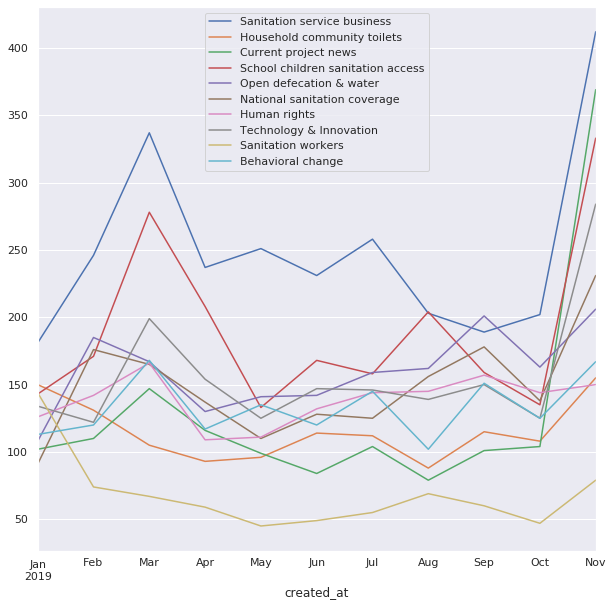

In [64]:
# Count up and plot in one go
sani_tweets_topics.plot(figsize=(10, 10)

In [0]:
# We need to create a "dictionary of curves"

curves_dict = {}
for col in sani_tweets_topics.columns:
  curves_dict[col] = hv.Curve(sani_tweets_topics[col])

In [0]:
# And render them into an overlay

ndoverlay = hv.NdOverlay(curves_dict, kdims='frequency').opts(width=900, height=700, xlabel='date', ylabel='n tweets',  tools=['hover'])

In [67]:
# now: show!
show(hv.render(ndoverlay))

/usr/local/lib/python3.6/dist-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/usr/local/lib/python3.6/dist-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/usr/local/lib/python3.6/dist-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/usr/local/lib/python3.6/dist-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
